<a href="https://colab.research.google.com/github/FatemehMomeni/BigData4/blob/main/BigData_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 51.0 MB/s 


In [3]:
import os
from google.colab import drive

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Reading files from google drive**

In [4]:
import pyspark
from pyspark.sql import SparkSession

# Creating spark session
spark = SparkSession.builder.master("local").appName("LogisticRegression").getOrCreate()

# Reading csv file with first row values as column names and converting numeric columns to double
dataset = spark.read.csv("/content/gdrive/MyDrive/Colab Notebooks/data.csv", header=True, inferSchema=True)

**Separating rows have null values**

In [6]:
from pyspark.sql.functions import col, isnan, when, count

null_dataset = dataset.filter(col('Label').isNull())
train_dataset = dataset.filter(col('Label').isNotNull())
column_names = dataset.columns

**Removing duplicates**

In [7]:
train_dataset = train_dataset.distinct()

**Separating columns according to their data types (SeniorCitizen is in string type columns)**

In [8]:
# Printing columns data type
print(dataset.printSchema())

double_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
string_columns = [name for name in column_names if name not in double_columns]

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)

None


**Filling missing values with mean and mode**

In [9]:
modes = [train_dataset.groupBy(c).count().orderBy('count', ascending=False).first()[0] for c in string_columns]
means = [train_dataset.groupBy(c).avg(c).first()[0] for c in double_columns]
indices = [5, 18, 19] # indicies of double columns

for i in range(len(indices)):
    modes.insert(indices[i], means[i])

modes[0] = 'unknown'
for column in range(len(modes)):
    train_dataset = train_dataset.na.fill(value=modes[column], subset=[column_names[column]])

**Plotting Charts**

Bar Chart for categirical features

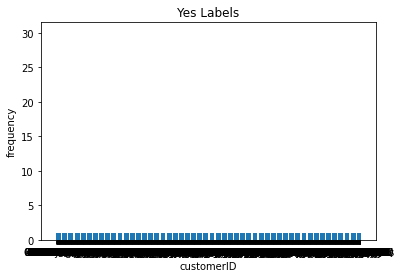

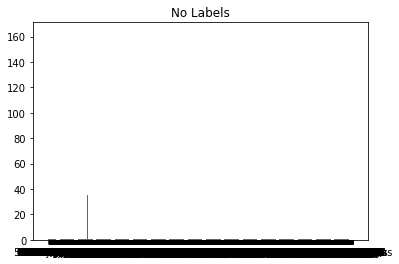

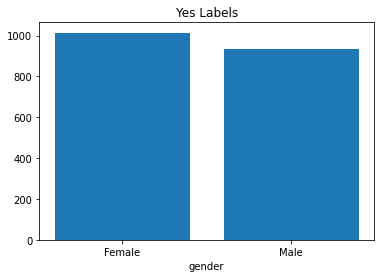

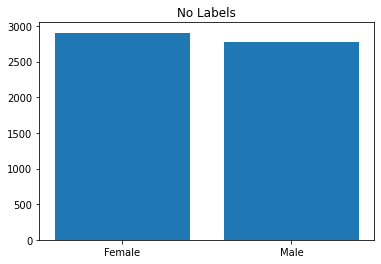

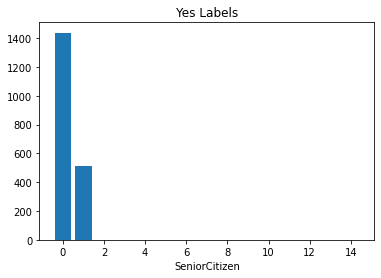

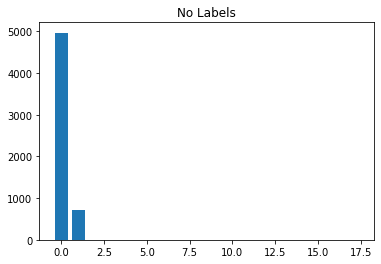

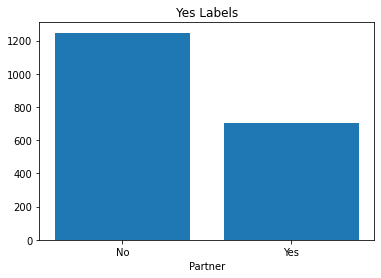

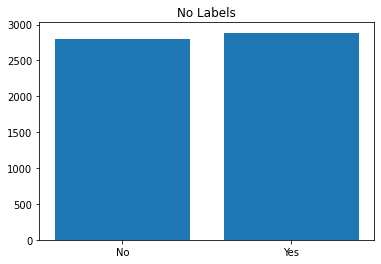

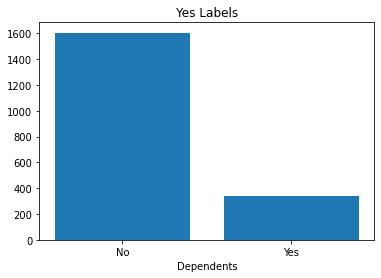

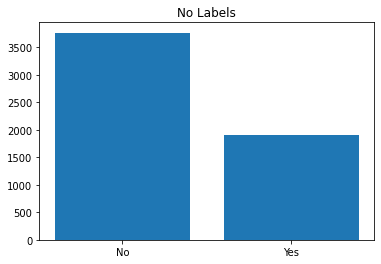

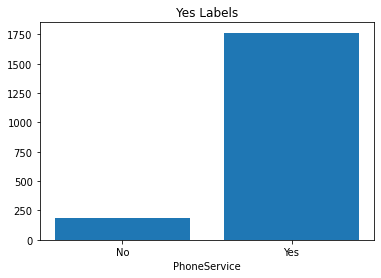

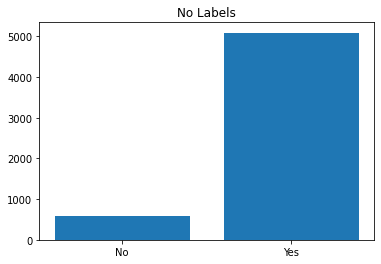

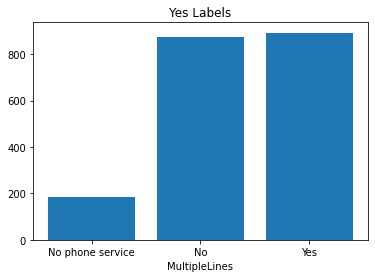

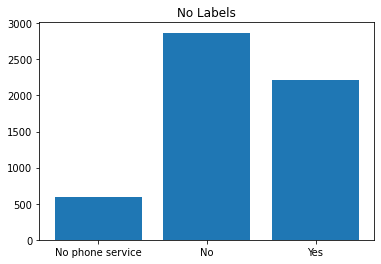

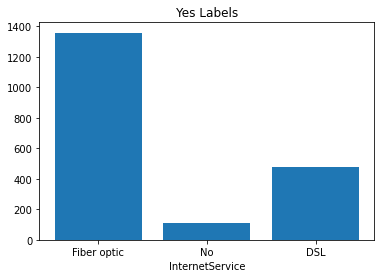

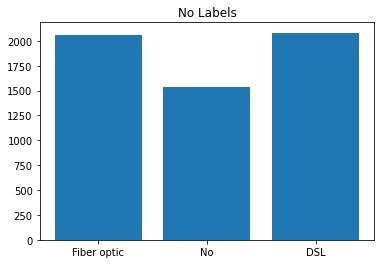

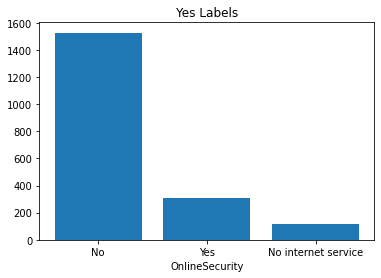

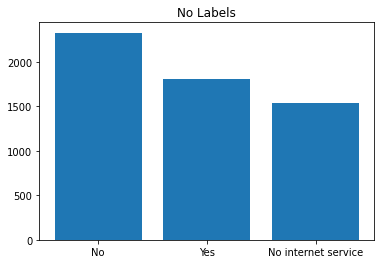

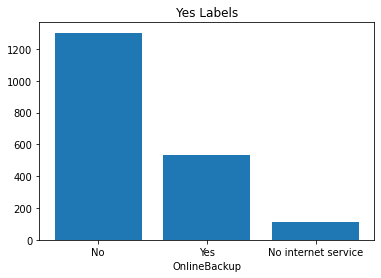

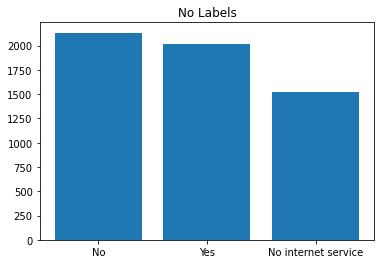

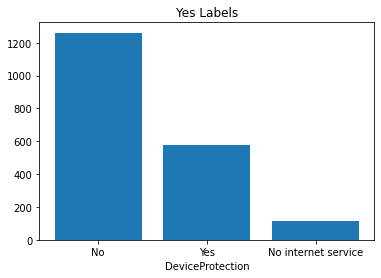

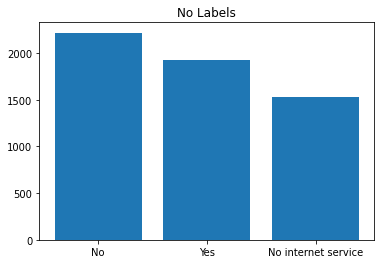

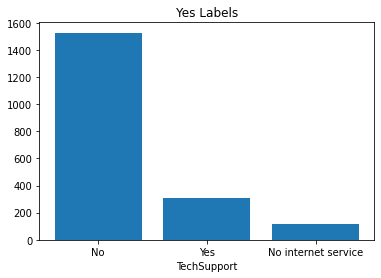

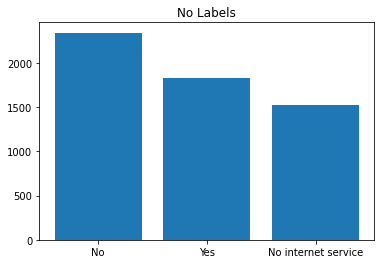

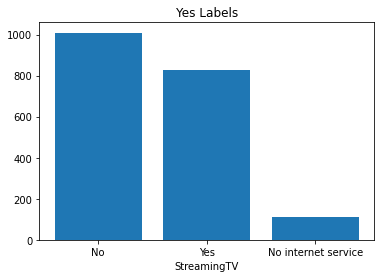

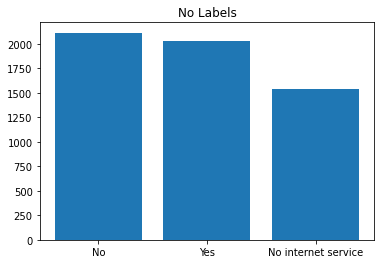

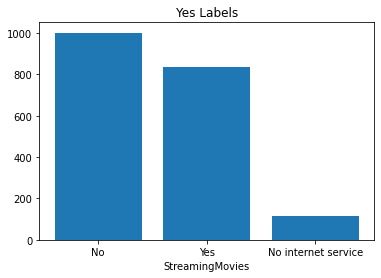

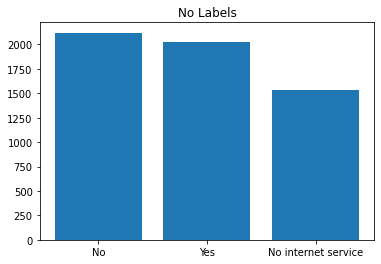

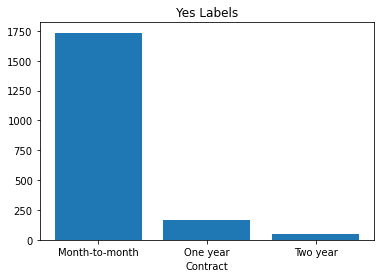

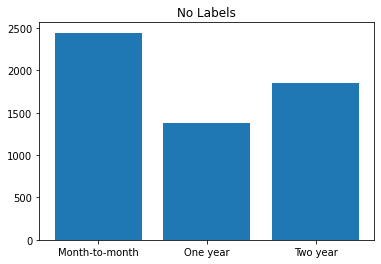

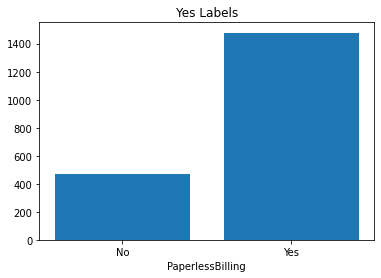

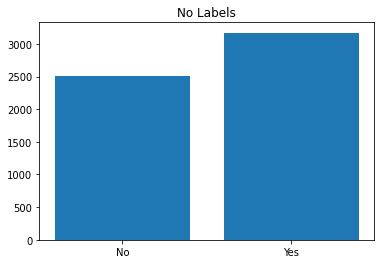

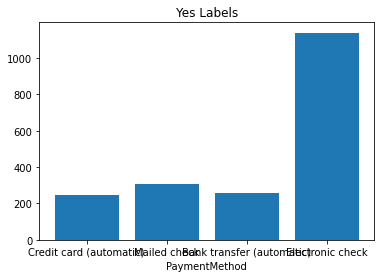

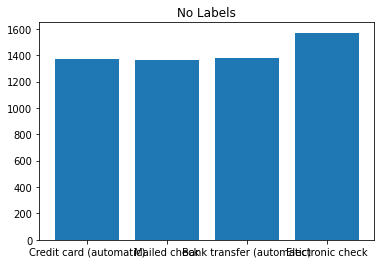

In [ ]:
import matplotlib.pyplot as plt

yes_df = train_dataset.where(train_dataset.Label == 'Yes')
no_df = train_dataset.where(train_dataset.Label == 'No')
plt.ylabel('frequency')

for c in column_names:
  if c not in double_columns + ['Label']:
    num_yes_df = yes_df.groupBy(c).count()
    y_yes = [data[0] for data in num_yes_df.select('count').collect()]
    x_yes = [data[0] for data in num_yes_df.select(c).collect()]

    num_no_df = no_df.groupBy(c).count()
    y_no = [data[0] for data in num_no_df.select('count').collect()]
    x_no = [data[0] for data in num_no_df.select(c).collect()]

    plt.bar(x_yes, y_yes)
    plt.title('Yes Labels')
    plt.xlabel(c)
    plt.show()
    
    plt.bar(x_no, y_no)
    plt.title('No Labels')
    plt.show()

Scatter Plot for numeric features

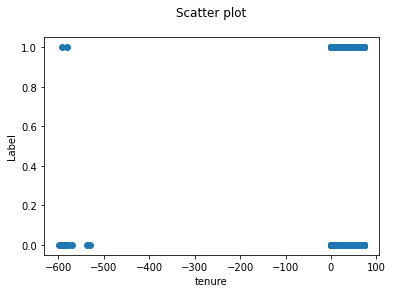

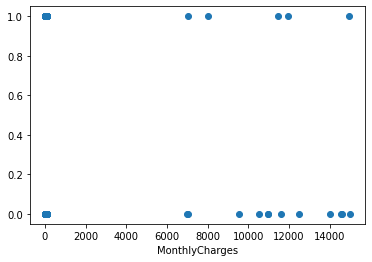

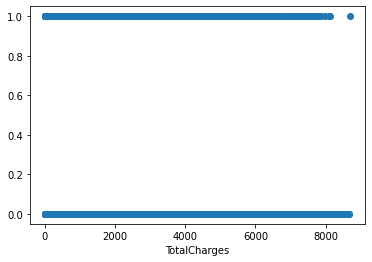

In [ ]:
plt.title('Scatter plot\n')
plt.ylabel('Label')
for c in column_names:
  if c not in string_columns + ['Label']:
    x = [data[0] for data in train_dataset.select(col(c)).collect()]   
    y = [data[0] for data in train_dataset.select(col('Label')).collect()]        
    y = list(map(lambda x:0 if x=='No' else 1,y))    
    plt.scatter(x, y)
    plt.xlabel(c)    
    plt.show()

**String Indexing**

In [10]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=c, outputCol=c+'_index').fit(train_dataset) for c in string_columns]
pipeline = Pipeline(stages=indexers)
indexed = pipeline.fit(train_dataset).transform(train_dataset)

for c in string_columns:
    indexed = indexed.drop(c)
    indexed = indexed.withColumnRenamed(c+'_index', c)

In [ ]:
print(indexed.show())

+------+--------------+------------+----------+------+-------------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|tenure|MonthlyCharges|TotalCharges|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|Label|
+------+--------------+------------+----------+------+-------------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|  69.0|        113.25|     7895.15|    2577.0|   0.0|          0.0|    1.0|       1.0|         0.0|          1.0|            0.0|           1.0|         1.0|             1.0|        1.0|        1.0|            1.0

**Get correlation matrix**

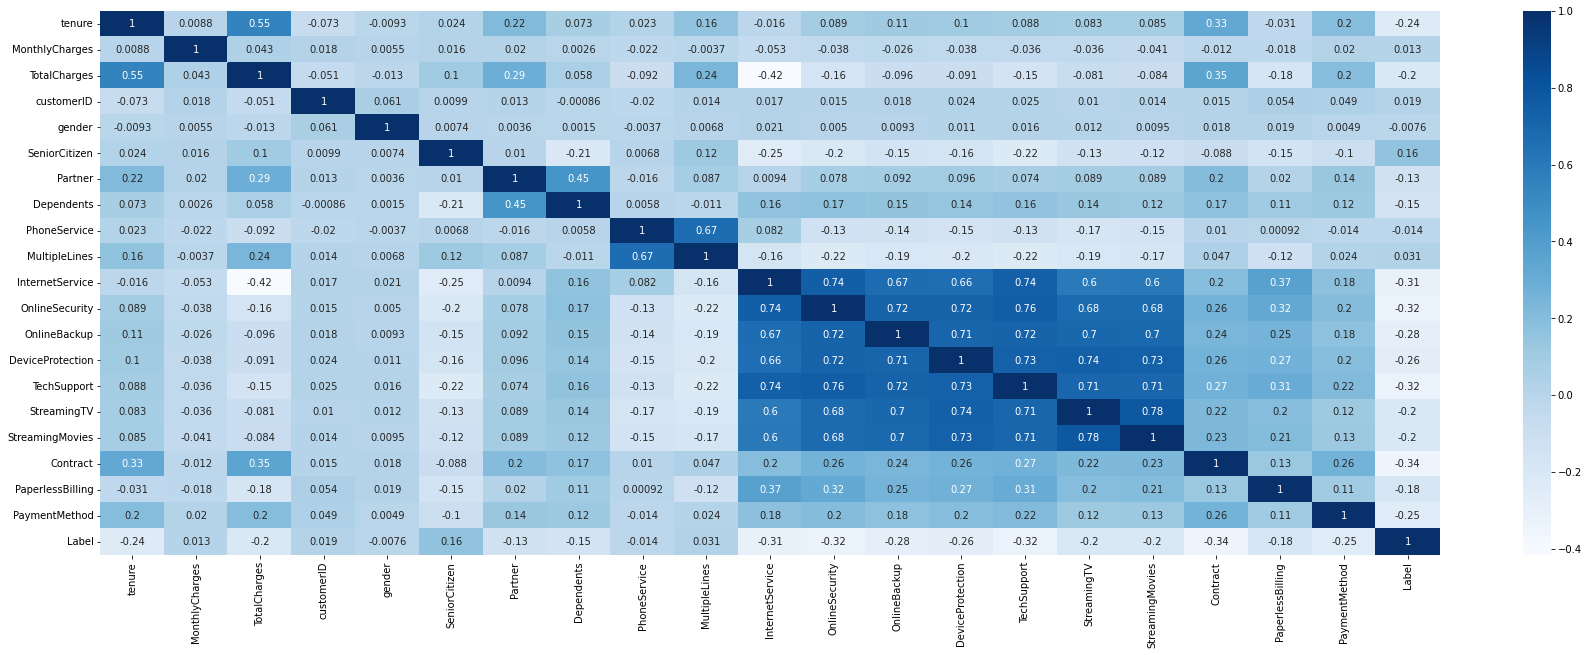

In [ ]:
import seaborn as sns

p_indexed = indexed.toPandas()
plt.figure(figsize=(30,10))
sns.heatmap(p_indexed.corr(), annot=True, cmap='Blues')
plt.show()

**Removing features**

In [ ]:
for c in ['StreamingMovies','OnlineSecurity','InternetService','DeviceProtection','OnlineBackup']:
  indexed = indexed.drop(c)
indexed = indexed.drop('customerID')

print(indexed.printSchema())

root
 |-- tenure: double (nullable = false)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- gender: double (nullable = false)
 |-- SeniorCitizen: double (nullable = false)
 |-- Partner: double (nullable = false)
 |-- Dependents: double (nullable = false)
 |-- PhoneService: double (nullable = false)
 |-- MultipleLines: double (nullable = false)
 |-- TechSupport: double (nullable = false)
 |-- StreamingTV: double (nullable = false)
 |-- Contract: double (nullable = false)
 |-- PaperlessBilling: double (nullable = false)
 |-- PaymentMethod: double (nullable = false)
 |-- Label: double (nullable = false)

None


**Vector Assembler**

In [11]:
input_columns = indexed.columns
input_columns.remove('Label')
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
transformed = assembler.transform(indexed)

**Logistic Regression**

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol='features',labelCol='Label',maxIter=5000)
train, test = transformed.randomSplit([0.8,0.2])
fit_model = lr.fit(train)
results = fit_model.transform(test)
evaluation = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Label')
results = results.select('Label','prediction')
AUC = evaluation.evaluate(results)
print("AUC score is : ",AUC)

AUC score is :  0.7205050680819594


**Without preprocissing**

Filling missing values with 0 and empty string

In [48]:
miss_str = list()
for c in string_columns:
  if c!='Label':
    if c!='SeniorCitizen':
      miss_str.append('')
    else:
      miss_str.append(0)
  else:
    miss_str.append('No')
miss_int = [0 for c in double_columns]

for i in range(len(indices)):
    miss_str.insert(indices[i], miss_int[i])

train_dataset2 = dataset.alias('train_dataset2')
for column in range(len(miss_str)):
    train_dataset2 = train_dataset2.na.fill(value=miss_str[column], subset=[column_names[column]])

String Indxing

In [49]:
indexers2 = [StringIndexer(inputCol=c, outputCol=c+'_index').fit(train_dataset2) for c in string_columns]
pipeline2 = Pipeline(stages=indexers2)
indexed2 = pipeline2.fit(train_dataset2).transform(train_dataset2)

for c in string_columns:
    indexed2 = indexed2.drop(c)
    indexed2 = indexed2.withColumnRenamed(c+'_index', c)

Vector Assembler

In [50]:
transformed2 = assembler.transform(indexed2)

Logostoc Regression

In [52]:
train2, test2 = transformed2.randomSplit([0.8,0.2])
fit_model2 = lr.fit(train2)
results2 = fit_model.transform(test2)
evaluation2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Label')
results2 = results2.select('Label','prediction')
AUC = evaluation.evaluate(results2)
print("AUC score is : ",AUC)

AUC score is :  0.5074500306895593
